In [26]:
from ctypes import alignment
from Bio import AlignIO
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import numpy as np


file = open('aminoacids.sth')
alignments = AlignIO.read(file, "stockholm")

N = len(alignments) # 205264
sizeseq = len(alignments[0].seq) # 44

# Extract columns from the alignment
columns = [[] for _ in range(sizeseq)]
for i in range (sizeseq):
    for record in alignments:
        columns[i].append(record.seq[i])
# Eliminate repeated amino acids and gaps from columns
aminoacids = columns
for i in range(len(aminoacids)):
    aminoacids[i] = list(set(aminoacids[i]))
    if '-' in aminoacids[i]:
        aminoacids[i].remove('-')

# function for computing mutual information between two positions
def compute_mutual_inf(i,j):
    col1 = aminoacids[i]
    col2 = aminoacids[j]
    mi = 0.0
    for a in col1:
        p_a = sum(1 for x in columns[i] if x == a)/ N
        for b in col2:
            p_b = sum(1 for x in columns[j] if x == b)/ N
            p_ab = sum(1 for x, y in zip(columns[i], columns[j]) if x == a and y == b) / N
            if p_ab != 0 and p_a != 0 and p_b != 0:
                mi += p_ab * np.log(p_ab/ (p_a * p_b))
    return mi #if mi != float('-inf') else 0
    '''             
    if mi > 0.0011: # threshold !should be fixed
       mi = 1
    else:
        mi = 0
    return mi if mi != float('-inf') else 0
    '''
# Compute mutual info for all pairs of positions
mutual_inf = np.zeros((sizeseq, sizeseq))

for i in range(sizeseq):
    for j in range(sizeseq):
        mutual_inf[i,j] = compute_mutual_inf(i,j)
        
        
# Compute contact map
threshold = 0.005
def compute_contact_map(mi, threshold):
    if mi > threshold: # threshold !should be fixed
        mi = 1
    else:
        mi = 0
    return mi if mi != float('-inf') else 0

contact_map = np.zeros((sizeseq, sizeseq))

for i in range(sizeseq):
    for j in range(sizeseq):
        contact_map[i,j] = compute_contact_map(i,j)

with open('contact_map.lst', 'w') as file:
    file.write(str(sizeseq) + '\n')

    for i in range(sizeseq):
        for j in range(sizeseq):
            file.write(str(int(contact_map[i,j])) + '\n')
#print(contact_map)
#print(columns[1][:10])

In [27]:
# Calculate entropy
def entropy(mutual_inf):
    n = mutual_inf.shape[0]
    
    entropy = np.zeros(n)
    
    for i in range(n):
        mutual_inf_i = mutual_inf[i]
        entropy[i] = -np.sum(mutual_inf_i * np.log(mutual_inf_i + 1e-10))  # Adding a small value to avoid log(0)
    return entropy

entropies = entropy(mutual_inf)

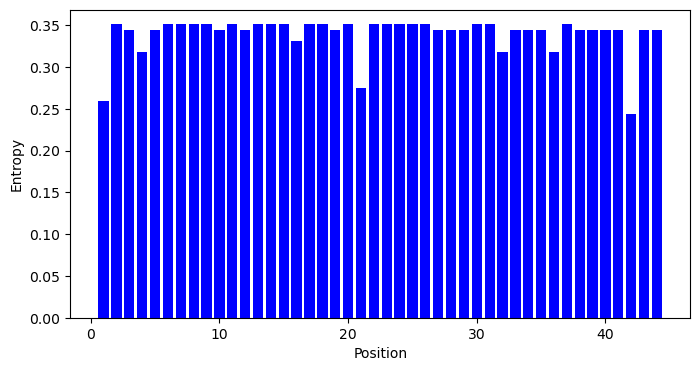

In [28]:
import matplotlib.pyplot as plt

# Plot entropy
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(entropies)+1), entropies, color='blue')
plt.xlabel('Position')
plt.ylabel('Entropy')
plt.savefig('entropy.png')
plt.show()
plt.close()

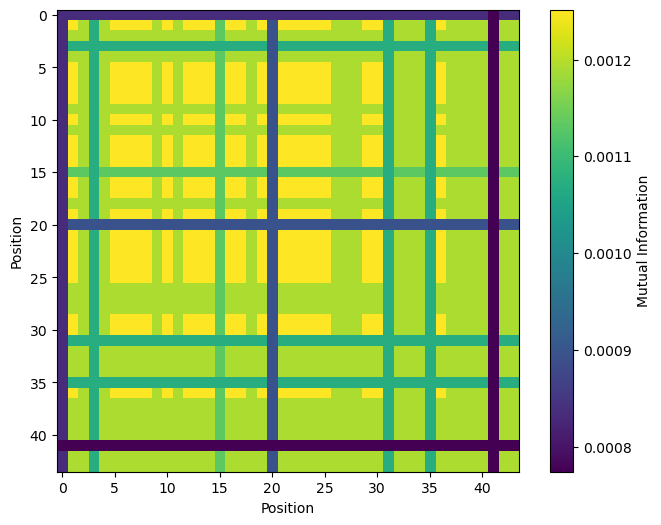

In [29]:
# Plot heatmap of mutual information
plt.figure(figsize=(8, 6))
plt.imshow(mutual_inf, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Mutual Information')
plt.xlabel('Position')
plt.ylabel('Position')
plt.savefig('heatmap.png')
plt.show()
plt.close()